## Description:

    * Use DeSeq2 to identify OTUs that are correlated with inorganic N concentration or differentially abundant between N fertilizer treatments.
   


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales",  "phyloseq",  "tidyr", 
           "reshape2", "vegan", "dplyr")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "tidyr"
[1] ‘0.6.0’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "dplyr"
[1] ‘0.5.0’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [5]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


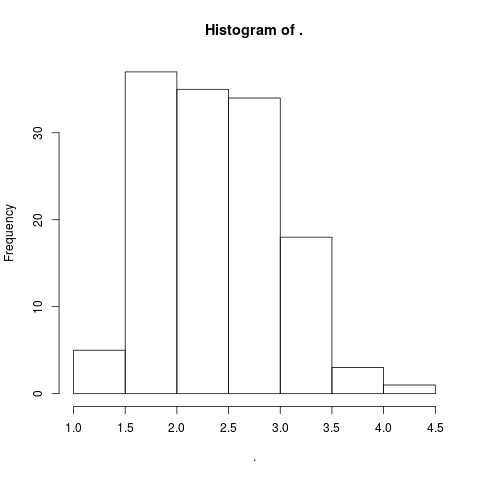

In [6]:
%%R
sample_data(physeq.Full)$InorganicN %>% log() %>% hist

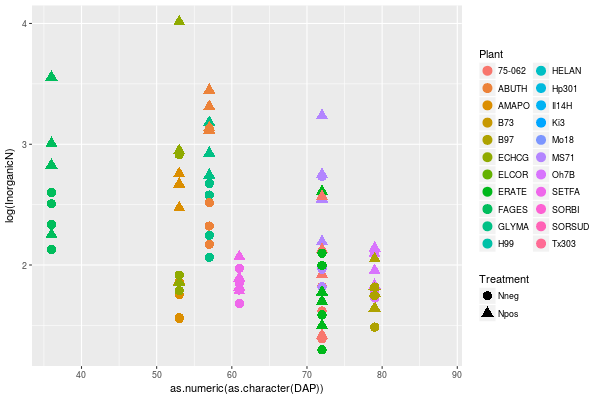

In [7]:
%%R -w 600 -h 400
sd = sample_data(physeq.Full)
sd = filter(sd, Plant != "BARE")
p = ggplot(sd, aes(x = as.numeric(as.character(DAP)), y = log(InorganicN), color = Plant, shape = Treatment)) + 
           geom_point(size = 4)
p 

In [8]:
%%R
sd %>% filter(InorganicN > 50) %>% .[,c("Plant", "Plot")]

  Plant Plot
1 ECHCG 1.24


In [13]:
%%R
Master = as(sample_data(physeq.Full), "data.frame")
str(Master)

'data.frame':	238 obs. of  55 variables:
 $ X.sample           : chr  "sample2-1.06_Npos" "sample6-4.27_Npos" "sample4-4.27_Nneg" "sample4-1.06_Nneg" ...
 $ Library            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Primer_Plate       : int  1 2 1 1 1 2 2 2 1 1 ...
 $ Primer_Well_ID     : Factor w/ 93 levels "A1","A10","A11",..: 93 63 16 51 82 27 48 39 27 7 ...
 $ primerFR_ID_byPlate: int  72 86 90 85 71 83 68 84 83 25 ...
 $ primerFR_ID_total  : int  72 182 90 85 71 179 164 180 83 25 ...
 $ barcode_ID         : int  72 182 90 85 71 179 164 180 83 25 ...
 $ PlotID             : Factor w/ 182 levels "1.03_Nneg","1.03_Npos",..: 6 178 177 5 5 103 103 104 104 33 ...
 $ Plant              : Factor w/ 23 levels "75-062","ABUTH",..: 6 6 6 6 6 6 6 6 6 1 ...
 $ Plot               : num  1.06 4.27 4.27 1.06 1.06 3.07 3.07 3.07 3.07 1.22 ...
 $ Treatment          : Factor w/ 2 levels "Nneg","Npos": 2 2 1 1 1 1 1 2 2 1 ...
 $ Rep                : int  1 4 4 1 1 3 3 3 3 1 ...
 $ DAP                : int 

In [32]:
%%R
Means = Master %>%
    filter(InorganicN < 45 | is.na(InorganicN)) %>%
    group_by(Plant, DAP, Treatment)  %>% 
     summarize(Ni = mean(InorganicN, na.rm = TRUE),
             Ni_se = (sd(InorganicN, na.rm = TRUE)/sqrt(length(InorganicN)))) %>%
    as.data.frame() %>%
    arrange(DAP) %>%
    mutate(Plant = factor(Plant, Plant),
          Value = paste(round(Ni,2), " (", round(Ni_se, 2), ")", sep = "")) %>%
    select(Plant, DAP, Treatment, Value)
head(Means)
   

  Plant DAP Treatment        Value
1  BARE  36      Nneg  9.62 (0.91)
2  BARE  36      Npos 14.48 (1.75)
3 FAGES  36      Nneg 11.12 (1.11)
4 FAGES  36      Npos 20.41 (5.36)
5 AMAPO  53      Nneg  5.43 (0.41)
6 AMAPO  53      Npos 12.13 (2.05)


In [42]:
%%R
TableOut = dcast(Means, Plant + DAP~Treatment)
TableOut

    Plant DAP         Nneg         Npos
1    BARE  36  9.62 (0.91) 14.48 (1.75)
2    BARE  53  9.82 (0.48) 30.01 (2.37)
3    BARE  57 10.92 (0.87) 27.44 (4.69)
4    BARE  61 12.92 (0.67) 22.29 (1.39)
5    BARE  72 11.47 (1.55) 19.38 (1.29)
6    BARE  79 10.79 (0.63) 19.23 (1.18)
7    BARE  84    NaN (NaN)    NaN (NaN)
8    BARE  88    NaN (NaN)    NaN (NaN)
9   FAGES  36 11.12 (1.11) 20.41 (5.36)
10  AMAPO  53  5.43 (0.41) 12.13 (2.05)
11  ECHCG  53  10.4 (4.02) 12.73 (6.32)
12  ABUTH  57 13.55 (3.19) 26.13 (2.08)
13  GLYMA  57 11.26 (1.56) 19.42 (2.16)
14  SETFA  61  6.24 (0.38)  6.67 (0.44)
15 75-062  72  5.88 (0.91)   8.1 (1.86)
16  ERATE  72  6.02 (1.05)   7.36 (2.1)
17    H99  72    NaN (NaN)    NaN (NaN)
18  Il14H  72    NaN (NaN)    NaN (NaN)
19   MS71  72  8.99 (2.15)  15.7 (3.52)
20    B73  79    NaN (NaN)    NaN (NaN)
21    B97  79  5.55 (0.39)  6.25 (0.55)
22  Hp301  79    NaN (NaN)    NaN (NaN)
23   Oh7B  79  6.31 (0.61)  7.48 (0.51)
24  HELAN  84    NaN (NaN)    NaN (NaN)


In [45]:
%%R
write.csv(TableOut, file = "/home/bryan/RhizCG/figures/InorganicNTable.csv", row.names = FALSE)

In [9]:
%%R
Val = sd %>% filter(!is.na(InorganicN & Plant != "BARE")) %>% dim %>% .[1] 
(paste(Val, "Number of rhizosphere samples with inorganic N measures")) %>% print

[1] "85 Number of rhizosphere samples with inorganic N measures"


In [10]:
%%R
sd %>% 
    filter(!is.na(InorganicN & Plant != "BARE")) %>%
    group_by(Plant) %>%
    summarize(n = length(InorganicN)) %>%
    print(n = 12)

# A tibble: 11 × 2
    Plant     n
   <fctr> <int>
1  75-062     8
2   ABUTH     8
3   AMAPO     8
4     B97     8
5   ECHCG     6
6   ERATE     8
7   FAGES     8
8   GLYMA     7
9    MS71     8
10   Oh7B     8
11  SETFA     8


In [11]:
%%R
physeq.Full %>% 
    sample_data() %>%
    filter(Plant %in% c("ECHCG")) %>%
    select(X.sample, InorganicN)

           X.sample InorganicN
1 sample2-2.10_Nneg   6.794068
2 sample2-3.20_Npos  19.050378
3 sample2-3.20_Nneg  18.428918
4 sample2-1.24_Npos  55.330111
5 sample2-1.24_Nneg   5.975813
6 sample2-2.10_Npos   6.412755


* missing values from some plants
* Two ECHCG missing because of improperly collected sample
* One GLYMA missing from extracts

### Notes:
* High inorganic N outlier will weight analysis.  Remove before proceeding. 

In [12]:
%%R

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels

#sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)

# remove inorganic N outliers
p = subset_samples(physeq.Full, InorganicN < 50)
#p = subset_samples(physeq.Full, !is.na(InorganicN))

physeq.plant = subset_samples(p, Plant != "BARE")
physeq.bare = subset_samples(p, Plant == "BARE")

p = NULL

In [13]:
%%R
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 84 samples ]
sample_data() Sample Data:       [ 84 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Create DeSeq2 object testing for inorganic N while controlling for plant

In [14]:
%%R

dds = phyloseq_to_deseq2(physeq.plant, ~Plant + log(InorganicN))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(physeq.plant)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "InorgN"
        NR = DF

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 20 workers

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates, MLE betas: 20 workers

  warnings.

 [1] "Intercept"       "Plant75.062"     "PlantABUTH"      "PlantAMAPO"     
 [5] "PlantB97"        "PlantECHCG"      "PlantERATE"      "PlantFAGES"     
 [9] "PlantGLYMA"      "PlantMS71"       "PlantOh7B"       "PlantSETFA"     
[13] "log.InorganicN."


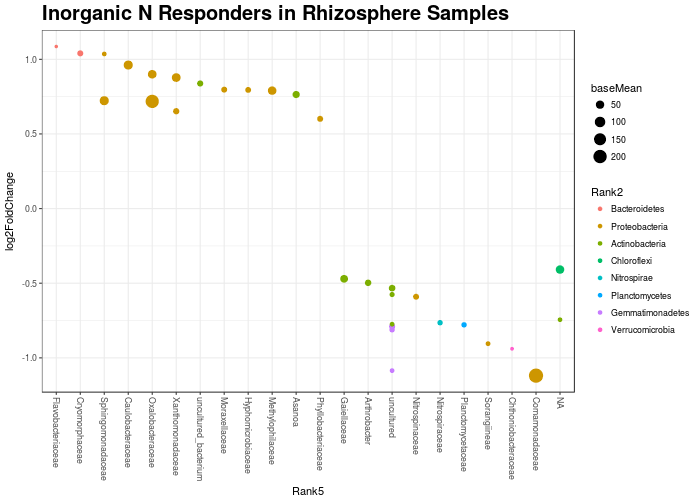

In [15]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       


p

In [16]:
%%R
paste(dim(sigtab)[1], "OTUs correlated with inorganic N concentration") %>% print

sigtab %>% 
    filter(log2FoldChange > 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs positively correlated with inorganic N concentration") %>% 
    print


sigtab %>% 
    filter(log2FoldChange < 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs negatively correlated with inorganic N concentration")%>% 
    print
 
sigtab %>% 
    filter(log2FoldChange < 0) %>% print

[1] "31 OTUs correlated with inorganic N concentration"
[1] "15 OTUs positively correlated with inorganic N concentration"
[1] "16 OTUs negatively correlated with inorganic N concentration"
     baseMean log2FoldChange     lfcSE      stat       pvalue        padj
1   53.245384     -0.4084517 0.1143557 -3.571765 3.545836e-04 0.036947973
2    5.376219     -1.0855173 0.2444750 -4.440198 8.987600e-06 0.005374585
3   16.123252     -0.7900934 0.2370669 -3.332787 8.598078e-04 0.049757910
4    9.925462     -0.8118271 0.2367709 -3.428745 6.063797e-04 0.041428888
5  237.777927     -1.1193100 0.2480444 -4.512539 6.405620e-06 0.005374585
6    5.967561     -0.9051376 0.2440945 -3.708144 2.087840e-04 0.026754183
7    2.612766     -0.9393266 0.2319705 -4.049336 5.136315e-05 0.013163641
8    9.521599     -0.7646658 0.2164511 -3.532742 4.112733e-04 0.036947973
9   14.837546     -0.5904819 0.1666668 -3.542889 3.957695e-04 0.036947973
10  39.100652     -0.4705226 0.1318108 -3.569681 3.574157e-04 0.036947

## Notes:
* Few OTUs respond to inorganic N concentration.  It is possible that the interaction between plant and N concentration is important
* Distribution is right skewed, so log transformation of inorganic N concentration is helpful


## Create DeSeq2 object testing for N treatment while controlling for plant
* using trimmed data set for which there is Inorganic N data

In [17]:
%%R

dds = phyloseq_to_deseq2(physeq.plant, ~Plant + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(physeq.plant)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "Ntreat_a"
        NR = rbind(NR, DF)

 [1] "Intercept"     "Plant75.062"   "PlantABUTH"    "PlantAMAPO"   
 [5] "PlantB97"      "PlantECHCG"    "PlantERATE"    "PlantFAGES"   
 [9] "PlantGLYMA"    "PlantMS71"     "PlantOh7B"     "PlantSETFA"   
[13] "TreatmentNneg" "TreatmentNpos"


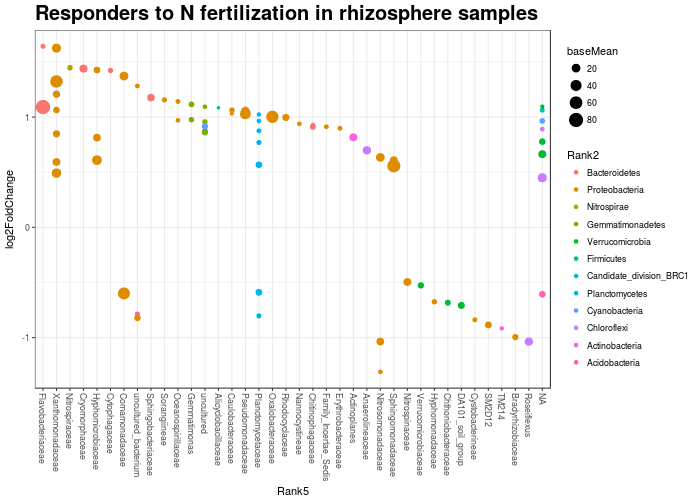

In [18]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 
NtreatResp1_6 = DF
p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Responders to N fertilization in rhizosphere samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [19]:
%%R
paste(dim(sigtab)[1], "OTUs respond to N fertilization") %>% print

sigtab %>% 
    filter(log2FoldChange > 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs positively respond to N fertilization") %>% 
    print


sigtab %>% 
    filter(log2FoldChange < 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs negatively respond to N fertilization")%>% 
    print
 
sigtab %>% 
    filter(log2FoldChange < 0) %>% print

[1] "76 OTUs respond to N fertilization"
[1] "58 OTUs positively respond to N fertilization"
[1] "18 OTUs negatively respond to N fertilization"
    baseMean log2FoldChange     lfcSE      stat       pvalue         padj
1  17.238544     -1.0367120 0.2496438 -4.152765 3.284817e-05 0.0044616380
2   2.462856     -0.7865645 0.2407576 -3.267040 1.086784e-03 0.0478670391
3   8.065210     -0.6064833 0.1727170 -3.511428 4.457059e-04 0.0262714166
4  13.606409     -1.0362939 0.2131742 -4.861254 1.166443e-06 0.0004048853
5   1.763324     -1.3107385 0.2851450 -4.596744 4.291448e-06 0.0009196179
6  51.345652     -0.5995283 0.1639463 -3.656858 2.553254e-04 0.0194545519
7   2.391334     -0.8389109 0.2459696 -3.410629 6.481333e-04 0.0349097993
8   9.196437     -0.8855276 0.2486477 -3.561375 3.689181e-04 0.0233386902
9   3.545734     -0.6755076 0.2067826 -3.266753 1.087887e-03 0.0478670391
10  6.420651     -0.9954052 0.2058352 -4.835933 1.325224e-06 0.0004139999
11  7.388263     -0.8209306 0.2530461 -3.

## Test N treatment effect in entire dataset


In [20]:
%%R
phy = subset_samples(physeq.Full, Plant != "BARE")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [21]:
%%R

dds = phyloseq_to_deseq2(phy, ~Plant + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "Ntreat_b"
        NR = rbind(NR, DF)

 [1] "Intercept"     "Plant75.062"   "PlantABUTH"    "PlantAMAPO"   
 [5] "PlantB73"      "PlantB97"      "PlantECHCG"    "PlantELCOR"   
 [9] "PlantERATE"    "PlantFAGES"    "PlantGLYMA"    "PlantH99"     
[13] "PlantHELAN"    "PlantHp301"    "PlantIl14H"    "PlantKi3"     
[17] "PlantMo18"     "PlantMS71"     "PlantOh7B"     "PlantSETFA"   
[21] "PlantSORBI"    "PlantSORSUD"   "PlantTx303"    "TreatmentNneg"
[25] "TreatmentNpos"


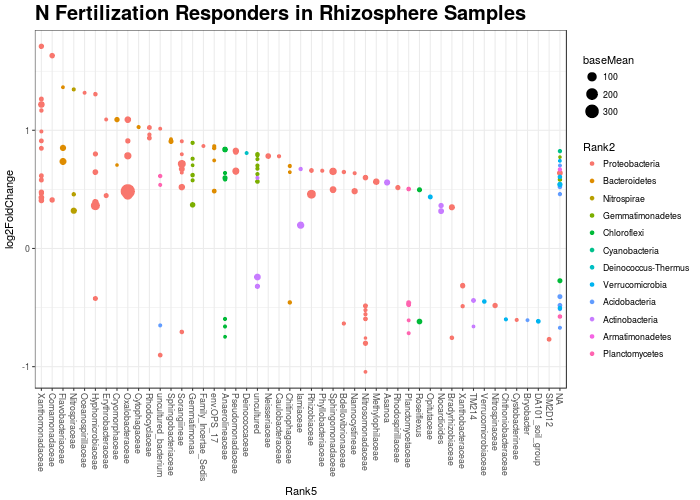

In [22]:
%%R -w 700 -h 500


sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

NtreatResp1_8 = DF

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("N Fertilization Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [23]:
%%R
paste(dim(sigtab)[1], "OTUs shift in response to nitrogen fertilization in entire dataset") %>% print

sigtab %>% 
    filter(log2FoldChange > 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs enriched in fertilized plots in entire dataset") %>% 
    print


sigtab %>% 
    filter(log2FoldChange < 0) %>% 
    dim %>%
    .[1] %>%
    paste(.,"OTUs declining in abundance in fertilized plots in entire dataset")%>% 
    print



[1] "163 OTUs shift in response to nitrogen fertilization in entire dataset"
[1] "118 OTUs enriched in fertilized plots in entire dataset"
[1] "45 OTUs declining in abundance in fertilized plots in entire dataset"


# Make figure of OTUs that are responders in N

In [24]:
%%R
head(NR)

          baseMean log2FoldChange     lfcSE        stat     pvalue padj
OTU.4087 0.1685120    -0.02509207 0.1360610 -0.18441786 0.85368566   NA
OTU.2009 0.7144240    -0.07719871 0.2439297 -0.31647938 0.75163867   NA
OTU.5899 0.2775791     0.07259113 0.2074549  0.34991282 0.72640413   NA
OTU.4181 0.2164358    -0.04653268 0.2071134 -0.22467251 0.82223405   NA
OTU.3052 0.3665593    -0.01442746 0.2199029 -0.06560834 0.94768965   NA
OTU.1890 1.0368276    -0.44810821 0.2481433 -1.80584442 0.07094265   NA
            Rank1         Rank2                Rank3                     Rank4
OTU.4087 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.2009 Bacteria           TM6 uncultured_bacterium                      <NA>
OTU.5899 Bacteria Acidobacteria                32-21      uncultured_bacterium
OTU.4181 Bacteria Elusimicrobia          Lineage_IIa      uncultured_bacterium
OTU.3052 Bacteria Elusimicrobia          Lineage_IIa uncultured_soil_bacterium
OTU.1890 Bacteria Elus

## what does base mean represent

In [25]:
%%R
Val = NR %>%
    filter(Test == "InorgN") %>%
    .$baseMean %>%
    sum()
paste("Normalized reads in Inorganic N test:", Val) %>% print

Val = NR %>%
    filter(Test == "Ntreat_a") %>%
    .$baseMean %>%
    sum()
paste("Normalized reads in N treatment test on samples with inorganic N measures:", Val) %>% print

Val = NR %>%
    filter(Test == "Ntreat_b") %>%
    .$baseMean %>%
    sum()
paste("Normalized reads in N treatment test on all samples:", Val) %>% print

[1] "Normalized reads in Inorganic N test: 26205.4573062836"
[1] "Normalized reads in N treatment test on samples with inorganic N measures: 26205.4573062836"
[1] "Normalized reads in N treatment test on all samples: 19493.0813359701"


In [26]:
%%R
temp = NR
temp$direction = ifelse(temp$log2FoldChange >= 0, "Pos", "Neg")
temp = filter(temp, padj < 0.05)
temp %>% head

   baseMean log2FoldChange     lfcSE      stat       pvalue        padj
1 53.245384     -0.4084517 0.1143557 -3.571765 3.545836e-04 0.036947973
2  5.376219     -1.0855173 0.2444750 -4.440198 8.987600e-06 0.005374585
3 16.123252     -0.7900934 0.2370669 -3.332787 8.598078e-04 0.049757910
4  9.925462     -0.8118271 0.2367709 -3.428745 6.063797e-04 0.041428888
5 15.452774      1.0400467 0.2460737  4.226565 2.372856e-05 0.007094839
6  2.474040      1.0858992 0.2413704  4.498891 6.830890e-06 0.005374585
     Rank1            Rank2            Rank3             Rank4
1 Bacteria      Chloroflexi           KD4-96              <NA>
2 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
3 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
4 Bacteria Gemmatimonadetes Gemmatimonadales Gemmatimonadaceae
5 Bacteria    Bacteroidetes    Flavobacteria  Flavobacteriales
6 Bacteria    Bacteroidetes    Flavobacteria  Flavobacteriales
              Rank5                Rank6               

In [27]:
%%R
colnames(temp)

 [1] "baseMean"       "log2FoldChange" "lfcSE"          "stat"          
 [5] "pvalue"         "padj"           "Rank1"          "Rank2"         
 [9] "Rank3"          "Rank4"          "Rank5"          "Rank6"         
[13] "Rank7"          "Rank8"          "OTU"            "Test"          
[17] "direction"     


In [28]:
%%R
theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
}

* The following figure utilizes the 'B' Ntreatment DESeq2 analysis and the inorganic N correlation in DESeq2, which represents more samples than inorganic N based analysis, but is consistent with summary of N treatment effects in text

In [29]:
%%R
##Colorpallete from trees
# Chloroflexi, #ff0000
# Acidobacteria, #1f78b4
# firmicutes, #ffff00
# proteobacteria #008000,
#  Gemmatoidetes, #ff8000
# Cyanobacteria, #e31a1c
# Bacteroidetes, #4b0082
# Verruco, #299a9f
# Planctomycetes, #00ff00,
# Candidate WS3, #cc4392
# Actinobacteria, #9a9a00

## add #000000 color for Nitrospirae 
PhylaColors = c("#1f78b4", "#9a9a00", "#4b0082", "#ff0000", "#e31a1c", "#ff8000", "#000000", 
    "#00ff00", "#008000", "#299a9f") 


In [30]:
%%R
temp$Rank2 %>% unique

 [1] Chloroflexi             Gemmatimonadetes        Bacteroidetes          
 [4] Proteobacteria          Verrucomicrobia         Nitrospirae            
 [7] Actinobacteria          Planctomycetes          Candidate_division_BRC1
[10] Acidobacteria           Firmicutes              Cyanobacteria          
[13] Deinococcus-Thermus     Armatimonadetes        
30 Levels: Acidobacteria Actinobacteria Armatimonadetes ... WCHB1-60


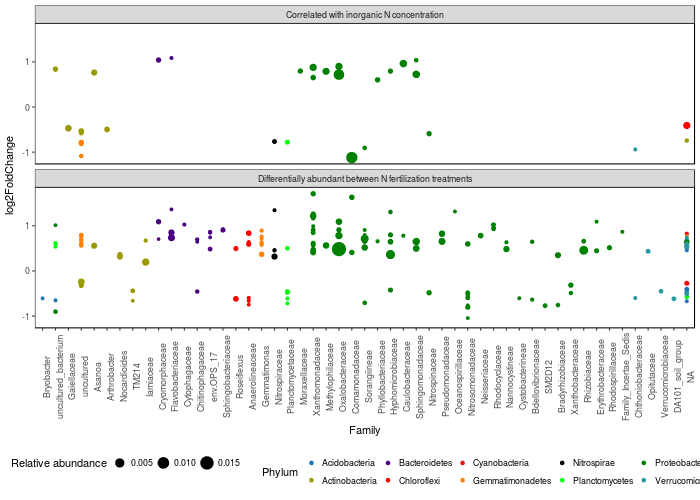

In [36]:
%%R -h 500 -w 700

NR$direction = ifelse(NR$log2FoldChange >= 0, "Pos", "Neg")
temp = filter(NR, padj < 0.05 & Test != "Ntreat_a")

#remove phyla that are not visible
temp = filter(temp, !Rank2 %in% c("Armatimonadetes", "Deinococcus-Thermus"))

temp = arrange(temp, Rank2)
temp = mutate(temp, Relative_Abundance = ifelse(Test == "Ntreat_b", baseMean/19493.08, baseMean/ 26205.46))
#temp = mutate(temp, TestLabel = ifelse(Test == "Ntreat_b"))
temp$Rank5 = factor(temp$Rank5, levels=temp$Rank5[order(temp$Rank2)], ordered=TRUE)
temp$Test = as.factor(temp$Test)
levels(temp$Test) = c("Correlated with inorganic N concentration", "Differentially abundant between N fertilization treatments")
P = ggplot(temp, aes(x = Rank5, y = log2FoldChange, color = Rank2, size = Relative_Abundance)) +
geom_point() + 
scale_color_manual(values = PhylaColors, guide_legend(title = "Phylum"))+
scale_size_continuous(guide_legend(title = "Relative abundance"))+
facet_wrap(~ Test, ncol = 1)+
theme_pub()+
xlab("Family")+
theme(axis.text.x = element_text(angle = 90), legend.position = "bottom")
P

# Save to file

In [37]:
%%R
svg(file = '/home/bryan/RhizCG/figures/ms_figures/Ntreatment.svg', width = 6.5, height = 6)
P %>% print
dev.off()

png 
  2 


# Write table of rhizosphere N responders to file

In [33]:
%%R
write.table(NR, file = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/Nresponders.txt', sep = "\t")
